In [5]:
#Get Duck Hunt installation files
!wget https://github.com/dash-uvic/ece471_536-S2022/raw/main/duck-hunt/ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl
!wget https://raw.githubusercontent.com/dash-uvic/ece471_536-S2022/main/duck-hunt/requirements.txt
!wget https://raw.githubusercontent.com/dash-uvic/ece471_536-S2022/main/duck-hunt/solution.py

--2022-02-05 02:50:10--  https://github.com/dash-uvic/ece471_536-S2022/raw/main/duck-hunt/ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dash-uvic/ece471_536-S2022/main/duck-hunt/ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl [following]
--2022-02-05 02:50:11--  https://raw.githubusercontent.com/dash-uvic/ece471_536-S2022/main/duck-hunt/ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35241639 (34M) [application/octet-stream]
Saving to: ‘ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl.2’

ece

In [3]:
#Install required files
!pip install -r requirements.txt
!pip install ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 15.7 MB 4.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Processing ./ece471_duckhunt-1.1.0-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 102 kB 4.2 MB/s 
     |████████████████████████████████| 60.4 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 41.3 MB/s 
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 47.7 MB 55 kB/s 
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656448 sha256=3de5f7abf1be1275535d1527c52cd1dcad557cf9eaa81285cec24a2bb2138f92
  Stored in directory: /root/.cache/pip/wheels/99/f7/e3/d6f0f120ac047c1e5de2ae34930e7bf6e8de1c7a4d5fa68555
Successfully built gym
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
  Attempting uninstall: albumentations
 

In [18]:
# The Google Colab doesn't have a visual display, so we need to fake one. 
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys

os.environ["SDL_VIDEODRIVER"] = "dummy"


In [19]:
import argparse
import gym
import cv2
import numpy as np
import pygame
from concurrent.futures import ThreadPoolExecutor

import ece471_duckhunt as dh
from ece471_duckhunt import envs
from ece471_duckhunt.envs import duckhunt_env


from solution import GetLocation

# Required version for the following packages
print(f"Duck Hunt version: {dh.__version__} (=1.0.0)")
print(f"OpenCV version: {cv2.__version__} (=4.X)")
print(f"NumPy version: {np.__version__} (=1.19+)")
print(f"OpenGym version: {gym.__version__} (=0.18.0)")


Duck Hunt version: 1.0.0 (=1.0.0)
OpenCV version: 4.5.5 (=4.X)
NumPy version: 1.19.5 (=1.19+)
OpenGym version: 0.18.0 (=0.18.0)


In [20]:
#Construct the Duck Hunt Environment
env = gym.make("DuckHunt-v0",
                    move_amount=1,
                    quiet=False,
                    level=1,
                    shape=(1024,798),
                    duration=60,
                    seed=None,
                    randomize=False,
                    )


Total number of levels: 820
{'length': 60, 'max_birds': 1, 'bird_speed': <BirdSpeed.slow: 1>, 'scene': ('foreground_alpha', 'background_1'), 'moving': False, 'atmosphere': [False, False, False, False], 'augment': [False, False, False, False], 'bamboozle': False, 'sprite-augment': [False, False, False], 'randomize': False, 'wind': False}


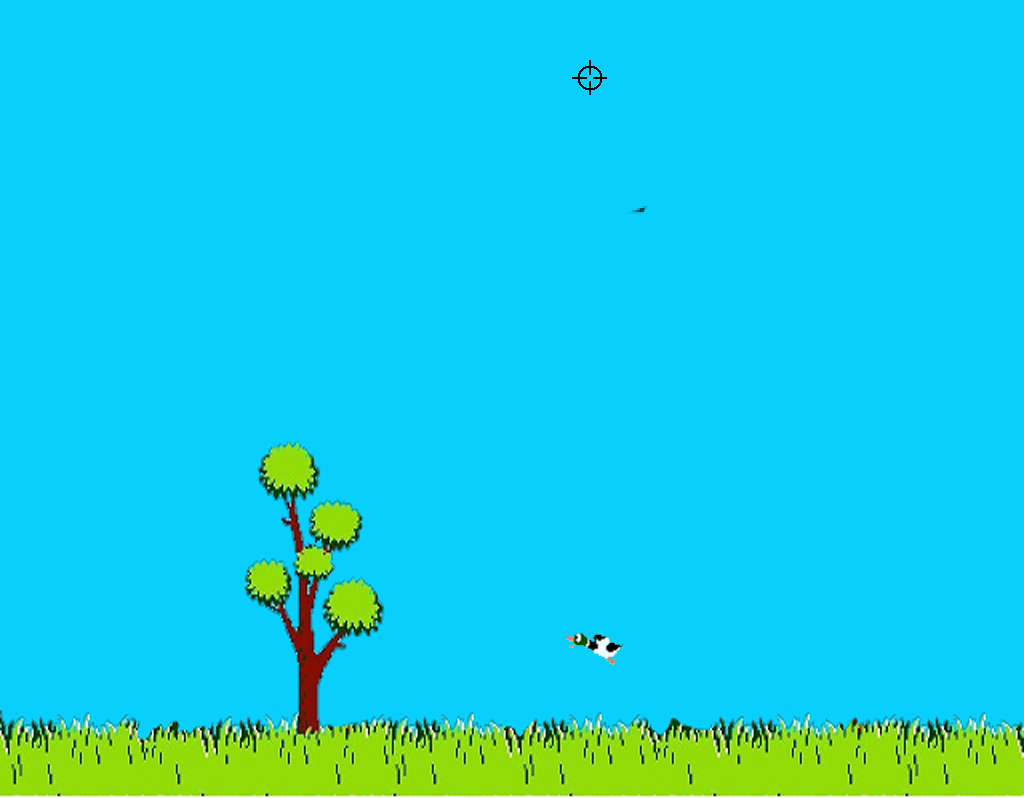

KeyboardInterrupt: ignored

In [21]:
#Run main animation loop
#NOTE: I am not creating a threaded operation, see duck_hunt_main.py for demo code
""" 
Use the `current_frame` from either env.step of env.render
to determine where to move the scope.

current_frame : np.ndarray (width, height, 3), np.uint8, RGB
"""
current_frame = env.render()
while True:
        
        """
        NOTE: This is a hack to display the scenes in Google Colab.
              I recommend using quiet=True or not displaying results
              and instead use Google Colab for training and your own computer
              for visualizing results
        """
        ##  convert from (width, height, channel) to (height, width, channel)
        #Display image, clear cell every 0.5 seconds
        output.clear()
        cv2_imshow(cv2.cvtColor(current_frame.transpose((1,0,2)), cv2.COLOR_RGB2BGR))
        
        
        #Using your algorithm, get a list of dictionaries with:
        # 'coordinate' : tuple or list (x,y) for absolute coordinates
        #                integer [0,8] for relative coordinates
        # 'move_type'  : type of move to perform
        results = GetLocation('absolute', env)  

        """
        Pass the current location (and location type) you want the "gun" place.
        The action "shoot" is automatically done for you.
        Returns: 
                current_frame: np.dnarray (W,H,3), np.uint8, RGB: current frame after `coordinate` is applied.
                level_done: True if the current level is finished, False otw 
                game_done: True if all the levels are finished, False otw 
                info: dict containing current game information (see API guide)
        
        """
        for res in results:
            coordinate  = res['coordinate']
            move_type   = res['move_type']
            current_frame, level_done, game_done, info = env.step(coordinate, move_type)
            print(info)
            if level_done or game_done:
                break
